In [5]:
import torch
print("PyTorch has version {}".format(torch.__version__))
import torch.nn as nn
import numpy as np
import os
import shutil

import torch_geometric
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, TransformerConv
import torch.nn.functional as F

np.random.seed(1)
from tqdm import tqdm


PyTorch has version 1.13.1


In [6]:
print(torch.cuda.is_available())

False


In [7]:
from MinCostDataset import MinCostDataset

dataset = MinCostDataset(root = "./data/")

In [8]:
def dataset_information(dataset):
    print(dataset)
    print(f"num features: {dataset.num_features}")
    print(f"num edge features: {dataset.num_edge_features}")
    print(f"first graph: {dataset[0]}")

dataset_information(dataset)

MinCostDataset(100)
num features: 1
num edge features: 2
first graph: Data(x=[77, 1], edge_index=[2, 230], edge_attr=[230, 2], y=[77, 2], reduced_cost=[230, 3], filename='netgen_72.txt')


In [9]:
def train_test_validation_split(dataset, train = 0.7, validation = 0.15):
    """
    Test split is 1 - train - validation
    """

    length = dataset.len()
    shuffled_dataset = np.arange(length)
    np.random.shuffle(shuffled_dataset)

    train_cutoff = int(train * length)
    validation_cutoff = int((train + validation) * length)

    train_data = shuffled_dataset[:train_cutoff]
    validation_data = shuffled_dataset[train_cutoff: validation_cutoff]
    test_data = shuffled_dataset[validation_cutoff:]

    return train_data, validation_data, test_data

In [10]:
def create_split_directories(dataset, split, split_name):
    src_folder = dataset.processed_dir
    dst_folder = os.path.join(dataset.root, split_name)

    # Remove files in case some were already present
    if os.path.exists(dst_folder):
        shutil.rmtree(dst_folder)
    os.makedirs(dst_folder)
    dst_index = 0
    for file_id in split:
        src_file_name = f"data_{file_id}.pt"
        # The files are always expected by PyG to be ordered
        dst_file_name = f"data_{dst_index}.pt"
        src = os.path.join(src_folder, src_file_name)
        dst = os.path.join(dst_folder, dst_file_name)
        shutil.copyfile(src, dst)
        dst_index += 1


In [11]:
def split_dataset(dataset, train_frac = 0.7, validation_frac = 0.15):
    train, validation, test = train_test_validation_split(dataset, train_frac, validation_frac)
    create_split_directories(dataset, train, "data_train/processed")
    create_split_directories(dataset, test, "data_test/processed")
    create_split_directories(dataset, validation, "data_validation/processed")
split_dataset(dataset, validation_frac = 0)

In [12]:
class CBN(torch.nn.Module):
    #TODO cite the colab
    def __init__(self, input_dim, output_dim, edge_feature_dim, args):
        super(CBN, self).__init__()

        hidden_dim = args.hidden_dim
        num_layers = args.num_layers
        dropout = args.dropout

        if num_layers > 1:
            conv_modules = [NNConv(input_dim, hidden_dim, nn.Linear(edge_feature_dim, input_dim * hidden_dim))]
            conv_modules.extend([NNConv(hidden_dim, hidden_dim, nn.Linear(edge_feature_dim, hidden_dim * hidden_dim)) for _ in range(num_layers - 2)])
            conv_modules.append(NNConv(hidden_dim, output_dim, nn.Linear(edge_feature_dim, hidden_dim * output_dim)))

            self.convs = nn.ModuleList(conv_modules)
        else:
            self.convs = nn.ModuleList([NNConv(input_dim, output_dim, nn.Linear(edge_feature_dim, input_dim * output_dim))])

        self.bns = nn.ModuleList([nn.BatchNorm1d(hidden_dim) for _ in range(num_layers - 1)])

        # self.post_mp = nn.Linear(hidden_dim, 1)

        self.num_layers = num_layers

        # Probability of an element getting zeroed
        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()
        # self.post_mp.reset_parameters()

    def forward(self, x, edge_index, edge_attr):
        for i in range(self.num_layers - 1):
            x = self.convs[i](x, edge_index, edge_attr)
            x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, self.dropout, self.training)
        x = self.convs[-1](x, edge_index, edge_attr)
        # x = F.relu(x)
        # x = self.post_mp(x)

        return x

    def dual_value(pred, x, edge_attr, edge_index):
        reduced_cost = edge_attr[:, 1] + pred[edge_index[0]].squeeze() - pred[edge_index[1]].squeeze()
        return -torch.dot(pred.squeeze(), x.squeeze()) - torch.dot(edge_attr[:, 0], F.relu(-reduced_cost))

    # def loss(self, pred, label, x, edge_index, edge_attr):
    #     # edge_attr[0] is capacity, edge_attr[1] is cost
    #     print(pred.shape)
    #     print(edge_index[0].shape)
    #     print(pred[edge_index[1]].shape)
    #     print(edge_attr[:, 1].shape)
    #     reduced_cost = pred[edge_index[1]].squeeze() - pred[edge_index[0]].squeeze() - edge_attr[:, 1]
    #     print(reduced_cost.shape)
    #     return label - torch.dot(pred.squeeze(), x.squeeze()) - torch.dot(edge_attr[:, 0], F.relu(reduced_cost))

In [247]:
class CBN_GAT(torch.nn.Module):
    #TODO cite the colab
    def __init__(self, input_dim, output_dim, edge_feature_dim, args):
        super(CBN_GAT, self).__init__()

        hidden_dim = args.hidden_dim
        num_layers = args.num_layers
        dropout = args.dropout

        if num_layers > 1:
            conv_modules = [TransformerConv(input_dim, hidden_dim, heads = args.heads, edge_dim = edge_feature_dim)]
            conv_modules.extend([TransformerConv(hidden_dim * args.heads, hidden_dim, heads = args.heads, edge_dim = edge_feature_dim) for _ in range(num_layers - 2)])
            conv_modules.append(TransformerConv(hidden_dim * args.heads, output_dim, heads = args.heads, edge_dim = edge_feature_dim))

            self.convs = nn.ModuleList(conv_modules)
        else:
            self.convs = nn.ModuleList([TransformerConv(input_dim, output_dim, heads = args.heads, edge_dim = edge_feature_dim)])

        self.bns = nn.ModuleList([nn.BatchNorm1d(hidden_dim) for _ in range(num_layers - 1)])

        # self.post_mp = nn.Linear(hidden_dim, 1)

        self.num_layers = num_layers

        # Probability of an element getting zeroed
        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()
        # self.post_mp.reset_parameters()

    def forward(self, x, edge_index, edge_attr):
        print("h")
        for i in range(self.num_layers - 1):
            x = self.convs[i](x, edge_index, edge_attr)
            x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, self.dropout, self.training)
        x = self.convs[-1](x, edge_index, edge_attr)
        # x = F.relu(x)
        # x = self.post_mp(x)

        return x

    def dual_value(N, p):
        return np.sum([p[i] * N.b[i] for i in N.V]) + np.sum([N.u[e] * max(0, p[e[1]] - p[e[0]] - N.c[e]) for e in N.E])

In [248]:
class DualLoss(nn.Module):
    def __init__(self):
        super(DualLoss, self).__init__()

    def forward(self, pred, label, x, edge_index, edge_attr):
        reduced_cost = edge_attr[:, 1] + pred[edge_index[0]].squeeze() - pred[edge_index[1]].squeeze()
        potentials = label[:, 1]
        opt = label[0, 0]
        opt_loss = (opt + torch.dot(pred.squeeze(), x.squeeze()) + torch.dot(edge_attr[:, 0], F.relu(-reduced_cost))) / opt
        potential_loss = torch.linalg.vector_norm(pred-potentials, ord=2)
        loss = opt_loss + 0.000005 * potential_loss
        print(f"opt_loss: {opt_loss}, 'pot_loss: {0.000005 * potential_loss}")
        return loss
        # edge_attr[0] is capacity, edge_attr[1] is cost
        reduced_cost = pred[edge_index[1]].squeeze() - pred[edge_index[0]].squeeze() - edge_attr[:, 1]

        reg = 0.0005 * sum(F.relu(-reduced_cost))

        return loss + reg

In [293]:
class CBN_GAT_reduced_cost(torch.nn.Module):
    #TODO cite the colab
    def __init__(self, input_dim, output_dim, edge_feature_dim, args):
        super(CBN_GAT_reduced_cost, self).__init__()

        hidden_dim = args.hidden_dim
        num_layers = args.num_layers
        dropout = args.dropout

        conv_modules = [TransformerConv(input_dim, hidden_dim, heads = args.heads, edge_dim = edge_feature_dim)]
        conv_modules.extend([TransformerConv(hidden_dim * args.heads, hidden_dim, heads = args.heads, edge_dim = edge_feature_dim) for _ in range(num_layers - 1)])

        self.convs = nn.ModuleList(conv_modules)

        self.bns = nn.ModuleList([nn.BatchNorm1d(hidden_dim * args.heads) for _ in range(num_layers - 1)])

        # self.predictor = nn.Linear(2 * hidden_dim * args.heads, output_dim)
        self.predictor = nn.Sequential(
            nn.Linear(2 * args.heads * hidden_dim, hidden_dim), nn.Dropout(args.dropout),
            nn.Linear(hidden_dim, output_dim))

        self.num_layers = num_layers

        # Probability of an element getting zeroed
        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()
        self.predictor.reset_parameters()

    def forward(self, x, edge_index, edge_attr):
        for i in range(self.num_layers - 1):
            x = self.convs[i](x, edge_index, edge_attr)
            x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, self.dropout, self.training)
        x = self.convs[-1](x, edge_index, edge_attr)
        edges = torch.concat((x[edge_index[0]], x[edge_index[1]]), dim = -1)
        x = self.predictor(edges)
        x = F.log_softmax(x, dim = 1)
        return x

    def loss(self):
        return nn.CrossEntropyLoss()

    def accuracy(self, preds, labels):
        predicted_classes = torch.argmax(preds, dim = 1)
        label_values = torch.argmax(labels, dim = 1)
        # print(preds[:10])
        # print(predicted_classes[:10])
        # print(labels[:10])
        # print(torch.where(predicted_classes == label_values, 1, 0)[:10])
        accuracy = torch.mean(torch.where(predicted_classes == label_values, 1, 0).float()).item()
        return round(accuracy, 4)


In [283]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

In [284]:
import torch.optim as optim

def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

In [296]:
#TODO handle batch size > 1
args = {
    'num_layers': 3,
    'batch_size': 1, # TODO implement
    'hidden_dim': 32,
    'heads': 4,
    'dropout': 0, #TODO put back for training
    'epochs': 50, # TODO put back to 500
    'opt': 'adam',
    'opt_scheduler': 'none',
    'opt_restart': 0,
    'weight_decay': 5e-3,
    'lr': 0.001,
    'model_type': "GAT"
}
args = objectview(args)


In [297]:
model = CBN_GAT_reduced_cost(1, 3, 2, args)
loss_fn = model.loss()
data = dataset[0]


scheduler, opt = build_optimizer(args, model.parameters())

for i in range(500):
    model.eval()
    opt.zero_grad()
    preds = model(data.x, data.edge_index, data.edge_attr)
    loss = loss_fn(preds, data.reduced_cost)
    print(f"loss: {loss.item()}")
    loss.backward()
    opt.step()
print(model.accuracy(preds, data.reduced_cost))
print(data)

loss: 2.5322763919830322
loss: 6.383935451507568
loss: 3.2436819076538086
loss: 1.3105891942977905
loss: 2.2963016033172607
loss: 2.2947781085968018
loss: 1.5433287620544434
loss: 0.9617912769317627
loss: 1.3167959451675415
loss: 1.611685037612915
loss: 1.2087196111679077
loss: 0.834313690662384
loss: 0.8661108016967773
loss: 1.015351414680481
loss: 1.0669523477554321
loss: 0.9550005197525024
loss: 0.7628633379936218
loss: 0.6728307604789734
loss: 0.6848090887069702
loss: 0.7870627641677856
loss: 0.6968690752983093
loss: 0.5640633702278137
loss: 0.560569167137146
loss: 0.6266055107116699
loss: 0.6454276442527771
loss: 0.6004884243011475
loss: 0.525609016418457
loss: 0.5461789965629578
loss: 0.5813808441162109
loss: 0.5477529764175415
loss: 0.4947778880596161
loss: 0.49248936772346497
loss: 0.5164047479629517
loss: 0.5192716717720032
loss: 0.49093693494796753
loss: 0.4601995646953583
loss: 0.4607696533203125
loss: 0.4715564250946045
loss: 0.4629460871219635
loss: 0.44121015071868896
los

In [309]:
import numpy as np
import torch
import torch.optim as optim
from tqdm import trange
import copy

from torch_geometric.loader import DataLoader

import matplotlib.pyplot as plt

train_loader = DataLoader(MinCostDataset(root = "./data/data_train"), batch_size = args.batch_size, shuffle = True)
test_loader = DataLoader(MinCostDataset(root = "./data/data_test"), batch_size = args.batch_size, shuffle = True)
# TODO also define the validation loader (and set validation fraction > 0 lol)

# Output dimension is 1 since we predict scalar potential values for each vertex
model = CBN_GAT_reduced_cost(1, 3, 2, args)
loss_fn = model.loss()
scheduler, opt = build_optimizer(args, model.parameters())

def train(args):

    # train
    losses = []
    train_accs = []
    test_accs = []
    test_losses = []
    best_acc = 0
    best_model = None
    for epoch in trange(args.epochs, desc="Training", unit="Epochs"):
        total_loss = 0
        total_accuracy = 0
        model.train()

        for batch in train_loader:
            opt.zero_grad()
            pred = model(batch.x, batch.edge_index, batch.edge_attr)
            # pred = pred[batch.train_mask]
            # label = label[batch.train_mask]
            loss = loss_fn(pred, batch.reduced_cost)
            loss.backward()
            opt.step()
            total_accuracy += model.accuracy(pred, batch.reduced_cost) * batch.num_graphs
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(train_loader.dataset)
        total_accuracy /= len(train_loader.dataset)
        losses.append(total_loss)
        train_accs.append(total_accuracy)

        if epoch % 10 == 0:
          test_acc, test_loss = test(test_loader, model)
          test_accs.append(test_acc)
          test_losses.append(test_loss)
          if test_acc > best_acc:
            best_acc = test_acc
            best_model = copy.deepcopy(model)
        else:
          test_accs.append(test_accs[-1])
          test_losses.append(test_losses[-1])

    return test_accs, test_losses, losses, train_accs, best_model, best_acc

def test(loader, test_model, is_validation=False, save_model_preds=False, model_type=None):
    # TODO handle is_validation
    test_model.eval()
    total_accuracy = 0
    total_loss = 0
    predictions = {}

    for batch in loader:
        with torch.no_grad():
            pred = model(batch.x, batch.edge_index, batch.edge_attr)
            # print(f"accuracy: {model.accuracy(pred, batch.reduced_cost)}")

            total_accuracy += model.accuracy(pred, batch.reduced_cost)
            total_loss += loss_fn(pred, batch.reduced_cost)

            # TODO handle save_model_preds (Q: how to keep track of which original file we're working on?) inspiration in commented code below

            # if save_model_preds:
            #     print ("Saving Model Predictions for Model Type", model_type)
            #
            #     data = {}
            #     data['pred'] = pred.view(-1).cpu().detach().numpy()
            #     data['label'] = label.view(-1).cpu().detach().numpy()
            #
            #     df = pd.DataFrame(data=data)
            #     # Save locally as csv
            #     df.to_csv('MinCostFlow-' + model_type + '.csv', sep=',', index=False)

    total_accuracy /= len(test_loader.dataset)
    total_loss /= len(test_loader.dataset)

    return total_accuracy, total_loss

Training: 100%|██████████| 50/50 [00:40<00:00,  1.23Epochs/s]

Maximum test set accuracy: 0.7525200000000001
Minimum loss: 0.5763220561402185
Minimum test loss: 0.5720123052597046



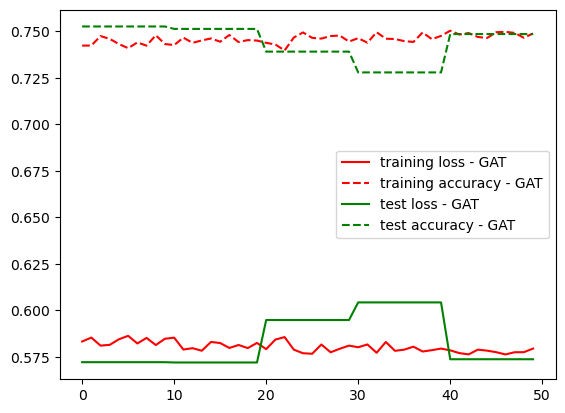

In [311]:
test_accs, test_losses, losses, train_accs, best_model, best_acc = train(args)

print("Maximum test set accuracy: {0}".format(max(test_accs)))
print("Minimum loss: {0}".format(min(losses)))
print("Minimum test loss: {0}".format(min(test_losses)))

# Run test for our best model to save the predictions!
# test(test_loader, best_model, is_validation=False, save_model_preds=True, model_type=model)
print()

plt.plot(losses, label="training loss" + " - " + args.model_type, color = 'red', linestyle='solid')
plt.plot(train_accs, label="training accuracy" + " - " + args.model_type, color = 'red', linestyle='dashed')
plt.plot(test_losses, label="test loss" + " - " + args.model_type, color = 'green', linestyle='solid')
plt.plot(test_accs, label="test accuracy" + " - " + args.model_type, color = 'green', linestyle='dashed')
plt.legend()
plt.show()

In [ ]:
true_pos = np.array([round(costs[neg_edges[j]] + y.value[neg_edges[j][0]] - y.value[neg_edges[j][1]], 4) for j in range(len(neg_edges))])
print(len(true_pos))
print(len(true_pos[true_pos < 0]))

In [ ]:
false_pos = np.array([round(costs[pos_edges[j]] + y.value[pos_edges[j][0]] - y.value[pos_edges[j][1]], 4) for j in range(len(pos_edges))])
print(len(false_pos[false_pos < 0]))
print(len(false_pos[false_pos == 0]))
print(len(false_pos))
#print(list(zip(pos_edges, false_pos)))

In [ ]:
reduced_cost = -preds[data.edge_index[1]].squeeze() + preds[data.edge_index[0]].squeeze() + data.edge_attr[:, 1]
reduced_cost = reduced_cost.detach().numpy().flatten()
threshold = np.quantile(reduced_cost[reduced_cost < 0], 0.1)
neg_edges = list(zip(*data.edge_index[:, reduced_cost < threshold].numpy()))
pos_edges = list(zip(*data.edge_index[:, reduced_cost > threshold].numpy()))
edges = list(zip(*data.edge_index.numpy()))
costs = dict(zip(edges, list(data.edge_attr[:, 1].numpy())))
caps = dict(zip(edges, list(data.edge_attr[:, 0].numpy())))
caps = np.array([caps[(i,j)] for (i,j) in pos_edges])

import cvxpy as cp
N = data.x.size(0)
y = cp.Variable(N)
t = cp.Variable(len(neg_edges))
s = cp.Variable(len(pos_edges))

prob = cp.Problem(
    cp.Minimize(10000*cp.sum(-cp.minimum(s, 0)) + 10*cp.norm(s.T @ caps, 1)),
    [
      *[costs[neg_edges[i]] + y[neg_edges[i][0]] - y[neg_edges[i][1]] <= t[i] for i in range(len(neg_edges))],
      *[costs[pos_edges[j]] + y[pos_edges[j][0]] - y[pos_edges[j][1]] == s[j] for j in range(len(pos_edges))],
      t <= -0.01
    ]
)

prob.solve()

y.value